In [4]:
import matplotlib.pyplot as plt
import requests
import pandas as pd
#import seaborn as sns

In [5]:
api_endpoint = 'https://data.cityofchicago.org/resource/fg6s-gzvg.json'
#?$limit=2000'
response = requests.get(api_endpoint)

if response.status_code == 200:
    # The request was successful
    data = response.json()  # If the response contains JSON data
    # Process or save the data as needed
else:
    # The request was not successful
    print(f"Error: {response.status_code}")
    print(response.text)  # Print the response content for debugging


In [6]:
df = pd.DataFrame(data)
df.head()

,trip_id,start_time,stop_time,bike_id,trip_duration,from_station_id,from_station_name,to_station_id,to_station_name,user_type,...,from_latitude,from_longitude,from_location,to_latitude,to_longitude,to_location,:@computed_region_rpca_8um6,:@computed_region_6mkv_f3dw,:@computed_region_vrxf_vc4k,:@computed_region_43wa_7qmu
0,25962904,2019-12-31T23:57:17.000,2019-12-31T23:59:18.000,5930,120,256,Broadway & Sheridan Rd,240,Sheridan Rd & Irving Park Rd,Subscriber,...,41.952833,-87.649993,"{'type': 'Point', 'coordinates': [-87.649993, ...",41.954245,-87.654406,"{'type': 'Point', 'coordinates': [-87.654406, ...",53,21186,57,39
1,25962903,2019-12-31T23:57:11.000,2020-01-01T00:05:45.000,2637,514,623,Michigan Ave & 8th St,52,Michigan Ave & Lake St,Subscriber,...,41.872773,-87.623981,"{'type': 'Point', 'coordinates': [-87.623981, ...",41.886024,-87.624117,"{'type': 'Point', 'coordinates': [-87.624117, ...",35,14913,38,10
2,25962902,2019-12-31T23:57:05.000,2020-01-01T00:05:46.000,863,520,623,Michigan Ave & 8th St,52,Michigan Ave & Lake St,Subscriber,...,41.872773,-87.623981,"{'type': 'Point', 'coordinates': [-87.623981, ...",41.886024,-87.624117,"{'type': 'Point', 'coordinates': [-87.624117, ...",35,14913,38,10
3,25962901,2019-12-31T23:56:34.000,2020-01-01T00:22:08.000,4877,1533,90,Millennium Park,90,Millennium Park,Subscriber,...,41.8810317,-87.62408432,"{'type': 'Point', 'coordinates': [-87.62408432...",41.8810317,-87.62408432,"{'type': 'Point', 'coordinates': [-87.62408432...",34,14309,38,36
4,25962900,2019-12-31T23:56:13.000,2020-01-01T00:15:45.000,2196,1172,112,Green St & Randolph St,225,Halsted St & Dickens Ave,Subscriber,...,41.883668,-87.64867,"{'type': 'Point', 'coordinates': [-87.64867, 4...",41.919936,-87.64883,"{'type': 'Point', 'coordinates': [-87.64883, 4...",44,14917,29,46


## EDA with data sample

In [7]:
df = pd.read_csv('rs_100000_2017_to_present.csv')

df.columns


Index(['trip_id', 'start_time', 'stop_time', 'bike_id', 'trip_duration',
       'from_station_id', 'from_station_name', 'to_station_id',
       'to_station_name', 'user_type', 'gender', 'birth_year', 'from_latitude',
       'from_longitude', 'from_location', 'to_latitude', 'to_longitude',
       'to_location'],
      dtype='object')

In [33]:
# format timestamp as a date
df['start_time_dt_fmt'] = pd.to_datetime(df['start_time'], format='%Y-%m-%dT%H:%M:%S.%f')

# Create a new column for month-year
df['month_year'] = df['start_time_dt_fmt'].dt.to_period('M')
df['year'] = df['start_time_dt_fmt'].dt.year
df['quarter'] = df['start_time_dt_fmt'].dt.to_period('Q')

df['trip_duration_min'] = df['trip_duration']/60

# Identify the top ten stations by the number of trips
top_stations = df['from_station_name'].value_counts().nlargest(10).index
df['from_station_name'].value_counts().nlargest(10)  #need more data?

from_station_name
Streeter Dr & Grand Ave         2045
Canal St & Adams St             1490
Clinton St & Madison St         1351
Clinton St & Washington Blvd    1290
Lake Shore Dr & Monroe St       1237
Columbus Dr & Randolph St       1051
Theater on the Lake              993
Lake Shore Dr & North Blvd       987
Michigan Ave & Washington St     947
Franklin St & Monroe St          936
Name: count, dtype: int64

In [36]:
def remove_outliers(group):
    Q1 = group['trip_duration_min'].quantile(0.25)
    Q3 = group['trip_duration_min'].quantile(0.75)
    IQR = Q3 - Q1
    return group[(group['trip_duration_min'] >= Q1 - 20 * IQR) & (group['trip_duration_min'] <= Q3 + 20 * IQR)]


df_no_outliers = df.groupby('year').apply(remove_outliers)

## on second thought we should just filter out anythin over 10 hours or something
df_no_outliers = df[df['trip_duration_min'] <= 60 * 10]

print(df_no_outliers['trip_duration_min'].describe())
df['trip_duration_min'].describe()


count    99918.000000
mean        17.240283
std         22.217557
min          1.000000
25%          6.700000
50%         11.483333
75%         20.150000
max        598.833333
Name: trip_duration_min, dtype: float64


count    100000.000000
mean         21.747527
std         528.063642
min           1.000000
25%           6.700000
50%          11.483333
75%          20.183333
max      130582.000000
Name: trip_duration_min, dtype: float64

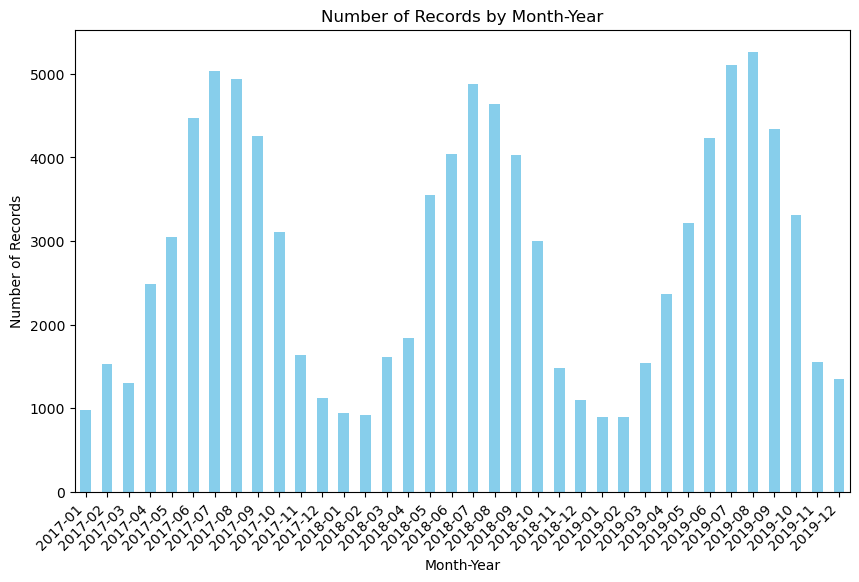

In [9]:
# Coverage of data

# Group by 'month_year' and count the number of records
monthly_counts = df['month_year'].value_counts().sort_index()

# Plot the number of records by month-year
plt.figure(figsize=(10, 6))
monthly_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Records by Month-Year')
plt.xlabel('Month-Year')
plt.ylabel('Number of Records')
plt.xticks(rotation=45, ha='right')
plt.show()

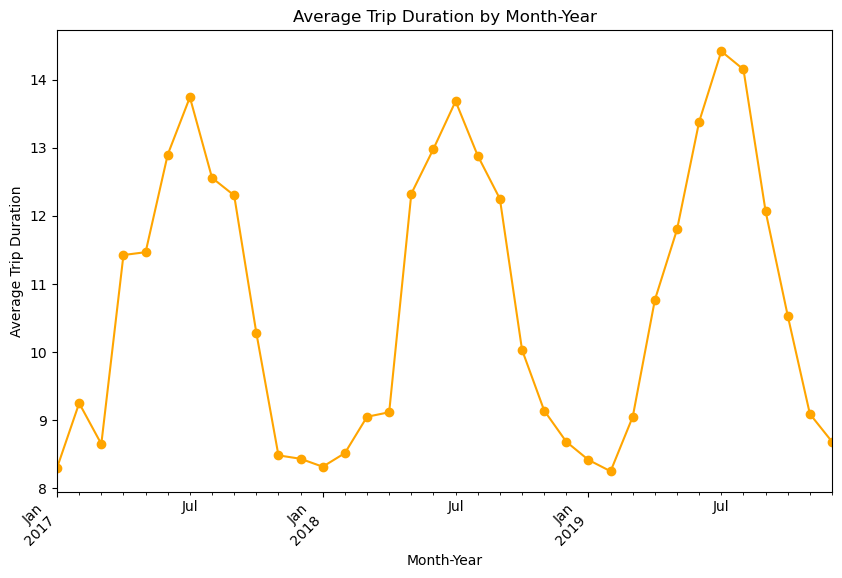

In [10]:
# median duration by for all stations
# if we want to use mean, need to do some careful data cleaning

# Group by 'month_year' and calculate the average trip duration
monthly_avg_duration = df.groupby('month_year')['trip_duration_min'].median()

# Plot the average trip duration by month-year
plt.figure(figsize=(10, 6))
monthly_avg_duration.plot(kind='line', marker='o', color='orange')
plt.title('Average Trip Duration by Month-Year')
plt.xlabel('Month-Year')
plt.ylabel('Average Trip Duration')
plt.xticks(rotation=45, ha='right')
plt.show()

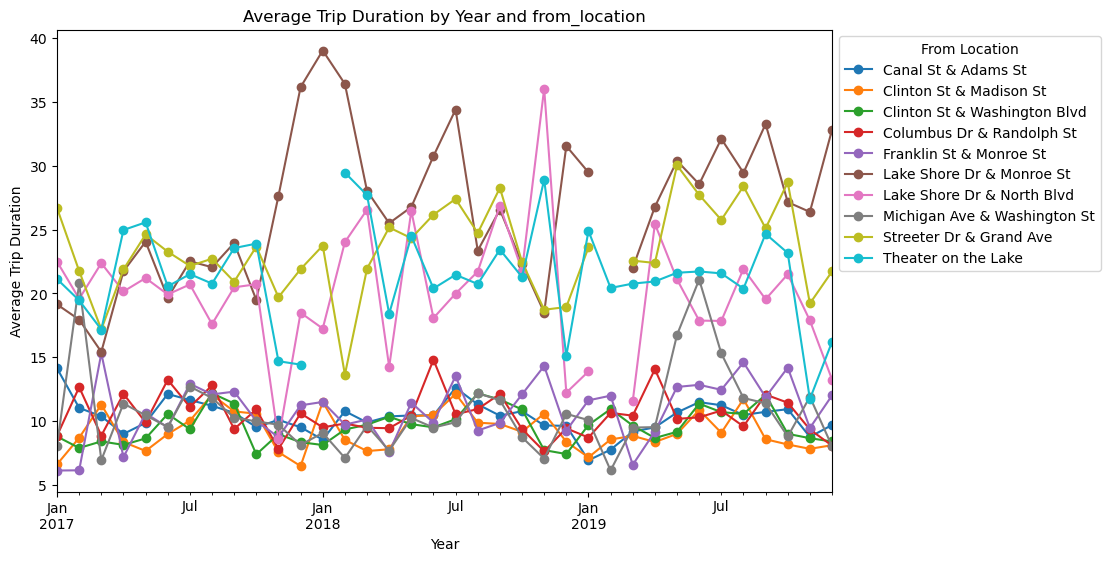

In [11]:
# median duration by for top stations
# if we want to use mean, need to do some careful data cleaning


# Filter the DataFrame to include only the top ten stations
df_top_stations = df[df['from_station_name'].isin(top_stations)]

# Group by 'from_location' and 'year,' calculate average trip duration
grouped_data = df_top_stations.groupby(['from_station_name', 'month_year'])['trip_duration_min'].median().reset_index()

# Pivot the data for plotting
pivot_data = grouped_data.pivot(index='month_year', columns='from_station_name', values='trip_duration_min')

# Plot the line plot
pivot_data.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Average Trip Duration by Year and from_location')
plt.xlabel('Year')
plt.ylabel('Average Trip Duration')
plt.legend(title='From Location', loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

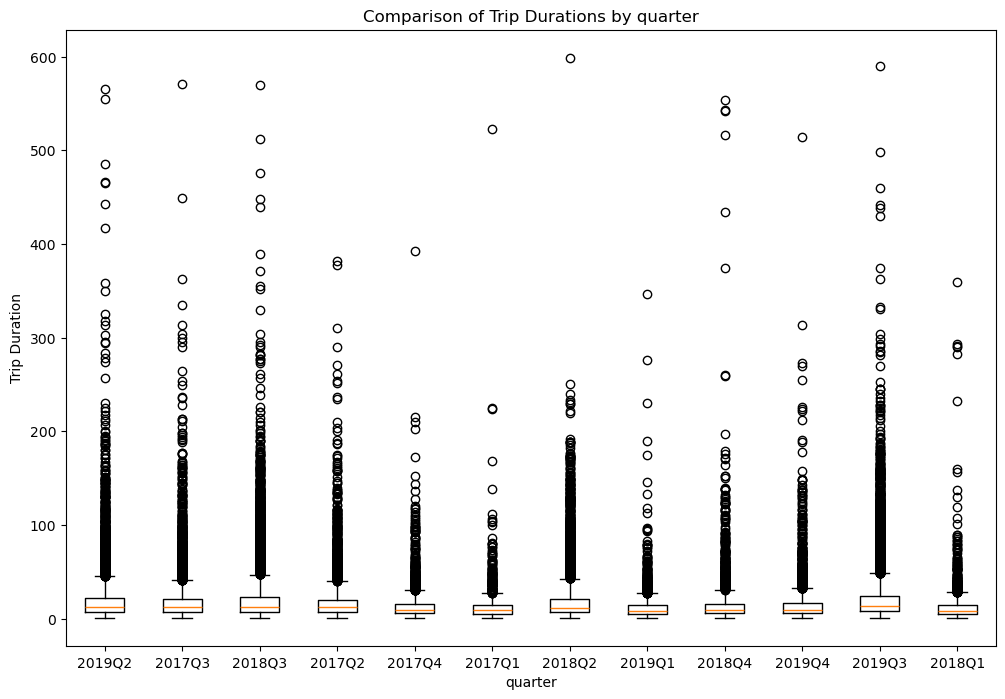

In [38]:
# Create a boxplot to compare the distribution of trip durations by year
plt.figure(figsize=(12, 8))
plt.boxplot([df_no_outliers[df_no_outliers['quarter'] == quarter]['trip_duration_min'] for quarter in df_no_outliers['quarter'].unique()], labels=df_no_outliers['quarter'].unique())
plt.title('Comparison of Trip Durations by quarter')
plt.xlabel('quarter')
plt.ylabel('Trip Duration')
plt.show()